In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/Deep/HW3/Codes/'

/content/drive/MyDrive/Colab Notebooks/Deep/HW3/Codes


## **Imports**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe
from torchtext.legacy import data

import numpy as np
import re
import gc
from tqdm import tqdm

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

#!pip install pytorch_pretrained_bert
from pytorch_pretrained_bert import BertTokenizer, BertModel

## **GloVe Models**

In [ ]:
def preprocessingText(text):
  text = text[0]
  if re.search('\w+:\/\/\S+', text) is not None:
    return [text, '@#$']

  text = re.sub('\w+:\/\/\S+', '', text)
  text = re.sub('((?<=[^A-Za-z])\')|(\'(?=[^A-Za-z]))', '', text)
  text = re.sub('@\S+', '', text)
  text = re.sub('[^A-Za-z0-9\s\']', '', text)
  text = re.sub('rt', '', text)
  text = re.sub('\s+', ' ', text)
  text = re.sub('(^\s+)|(\s+$)', '', text)
  text = text.lower()
  return text.split()

def preprocessingLabel(label):
  return float(label) / 4.0

def filter_pred(example):
  if example.text is None or len(example.text) == 0 or 0.4 < float(example.label) < 0.6 or example.text[-1] == '@#$':
    return False
  return True

TEXT = data.Field(tokenize=lambda x: [x], include_lengths=True, preprocessing=preprocessingText, batch_first=True)
LABEL = data.LabelField(dtype=torch.float, preprocessing=preprocessingLabel)

fields = [('label', LABEL), ('id', None), ('date', None), ('query', None), ('name', None), ('text', TEXT), ('category', None)]

path = '/content/drive/MyDrive/Colab Notebooks/Deep/HW3/Sentiment140/training.1600000.processed.noemoticon.utf8.csv'
dataset = data.TabularDataset(path=path, format='CSV', fields=fields, skip_header=False, filter_pred=filter_pred)
(train_data, valid_data) = dataset.split(split_ratio=[0.99, 0.01])

path = '/content/drive/MyDrive/Colab Notebooks/Deep/HW3/Sentiment140/testdata.manual.2009.06.14.csv'
test_data = data.TabularDataset(path=path, format='CSV', fields=fields, skip_header=False, filter_pred=filter_pred)

vector = GloVe(name='42B', dim=300, cache='/content/drive/MyDrive/Colab Notebooks/Deep/HW3/glove42b/')
MEAN_VECTOR = vector.vectors.mean(dim=0)

TEXT.build_vocab(dataset, vectors=vector)
LABEL.build_vocab(dataset)

print("Number of train data: {}".format(len(train_data)))
print("Number of valid data: {}".format(len(valid_data)))
print("Number of test data: {}".format(len(test_data)))


100%|█████████▉| 1917493/1917494 [05:50<00:00, 5475.90it/s]


Number of train data: 1511128
Number of valid data: 15264
Number of test data: 301


In [ ]:
# Part a & b
class LSTMTagger(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, bidirectional, TEXT, mean_vector):
    super(LSTMTagger, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.copy_(TEXT.vocab.vectors)

    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

    self.embedding.weight.data[UNK_IDX] = mean_vector
    self.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

    self.bidirectional = bidirectional
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=bidirectional, batch_first=True)
    self.hidden2tag = nn.Linear((int(bidirectional) + 1) * hidden_dim, output_dim)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, text, text_lengths):

    embedded = self.embedding(text)

    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
    _, (hidden, cell) = self.lstm(packed_embedded)

    if self.bidirectional:
      lstm_out = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
    else:
      lstm_out = hidden[-1,:,:]

    tag_scores = self.hidden2tag(lstm_out)
    tag_probs = self.softmax(tag_scores)
    return tag_probs


# Part c
class PLSTMTagger(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_level, TEXT, mean_vector):
    super(PLSTMTagger, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.copy_(TEXT.vocab.vectors)

    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

    self.embedding.weight.data[UNK_IDX] = mean_vector
    self.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

    self.num_level = num_level
    self.hidden_dim = hidden_dim

    self.lstms = [nn.LSTM(embedding_dim, hidden_dim, batch_first=True)]
    for i in range(num_level - 1):
      self.lstms.append(nn.LSTM(2 * hidden_dim, hidden_dim, batch_first=True))
    self.lstms = nn.Sequential(*self.lstms)

    self.hidden2tag = nn.Linear(hidden_dim, output_dim)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, text, text_lengths):

    text_lengths = text_lengths + torch.remainder(-text_lengths, 2 ** (self.num_level - 1))
    padded_text_len = torch.max(text_lengths) - text.shape[1]

    if padded_text_len != 0:
      padded = torch.ones(text_lengths.shape[0], padded_text_len, dtype=torch.int)
      if text.is_cuda:
        padded = padded.cuda()
      
      text = torch.cat((text, padded), dim=1)

    batch_size = text_lengths.shape[0]
    embedded = self.embedding(text)

    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
    packed_output, (hidden, cell) = self.lstms[0](packed_embedded)

    for i in range(1, self.num_level):
      
      output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

      output = output.contiguous().view(batch_size, -1, 2 * self.hidden_dim)
      output_lengths = torch.div(output_lengths, 2).to(torch.long)

      packed_embedded = nn.utils.rnn.pack_padded_sequence(output, output_lengths, batch_first=True)
      packed_output, (hidden, cell) = self.lstms[i](packed_embedded)

    tag_scores = self.hidden2tag(hidden[-1, :, :])
    tag_probs = self.softmax(tag_scores)
    return tag_probs


## **Training**

In [ ]:
# Part a & b
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_DIM = TEXT.vocab.vectors.shape[1]
HIDDEN_DIM = 150
OUTPUT_DIM = 2
BIDIR = False
BATCH_SIZE = 4000

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), sort_within_batch=True)

net = LSTMTagger(VOCAB_SIZE, EMBEDDING_DIM, EMBEDDING_DIM, OUTPUT_DIM, BIDIR, TEXT, MEAN_VECTOR)
if torch.cuda.is_available():
  net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.02)


In [ ]:
# Part c
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_DIM = TEXT.vocab.vectors.shape[1]
HIDDEN_DIM = 64
OUTPUT_DIM = 2
NUM_LEVEL = 4
BATCH_SIZE = 4000

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), sort_within_batch=True)

net = PLSTMTagger(VOCAB_SIZE, EMBEDDING_DIM, EMBEDDING_DIM, OUTPUT_DIM, NUM_LEVEL, TEXT, MEAN_VECTOR)
if torch.cuda.is_available():
  net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.02)


In [ ]:
# cleaning gpu memory
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_loss_vec = []
train_acc_vec = []

valid_loss_vec = []
valid_acc_vec = []

num_epochs = 5
period = max(round(len(train_iterator) / 50.0), 1)

for epoch in range(num_epochs):
  
  pbar = tqdm(train_iterator, total=len(train_iterator), leave=True, position=0)

  tr_epoch_loss = 0
  tr_epoch_acc = 0
  tr_count = 0

  for batch in pbar:
    text, text_lengths = batch.text
    label = batch.label

    if torch.cuda.is_available():
      text = text.cuda()
      label = label.cuda()

    net.train()
    optimizer.zero_grad()
    predictions = net(text, text_lengths)
    predictions = predictions.squeeze(1)
    
    loss = criterion(predictions, label.to(torch.long))
    acc = torch.sum(torch.argmax(predictions, dim=1) == label.to(torch.long)) / len(label)

    loss.backward()
    optimizer.step()

    tr_loss = loss.item()
    tr_acc = acc.item()

    train_loss_vec.append(tr_loss)
    train_acc_vec.append(tr_acc)
    
    tr_epoch_loss += tr_loss
    tr_epoch_acc += tr_acc
    
    if tr_count % period == 0:
      val_batch_loss = 0
      val_batch_acc = 0
      val_count = 0

      for val_batch in valid_iterator:
        text, text_lengths = val_batch.text
        label = val_batch.label

        if torch.cuda.is_available():
          text = text.cuda()
          label = label.cuda()

        net.eval()
        with torch.no_grad():
          predictions = net(text, text_lengths)
          predictions = predictions.squeeze(1)
          
          val_loss = criterion(predictions, label.to(torch.long))
          val_acc = torch.sum(torch.argmax(predictions, dim=1) == label.to(torch.long)) / len(label)
          
          val_batch_loss += val_loss.item()
          val_batch_acc += val_acc.item()
          val_count += 1
      
      val_batch_loss = val_batch_loss / val_count
      val_batch_acc = val_batch_acc / val_count
      
      valid_loss_vec.append(val_batch_loss)
      valid_acc_vec.append(val_batch_acc)
    
    tr_count += 1
    pbar.set_description(f'Training: loss={tr_loss:.6f} acc={tr_acc:.3f} | Validation: loss={val_batch_loss:.6f} acc={val_batch_acc:.3f} | epoch={epoch + 1}/{num_epochs}')
  
  tr_epoch_loss = tr_epoch_loss / tr_count
  tr_epoch_acc = tr_epoch_acc / tr_count
  print(f'Training: epoch loss={tr_epoch_loss:.6f}, epoch acc={tr_epoch_acc:.3f} | Validation: epoch loss={val_batch_loss:.6f}, epoch acc={val_batch_acc:.3f} | epoch={epoch + 1}/{num_epochs}')
  print()


Training: loss=0.839512 acc=0.474 | Validation: loss=0.805218 acc=0.508 | epoch=1/5:  11%|█         | 40/378 [00:27<03:55,  1.43it/s]


KeyboardInterrupt: ignored

## **Evaluation**

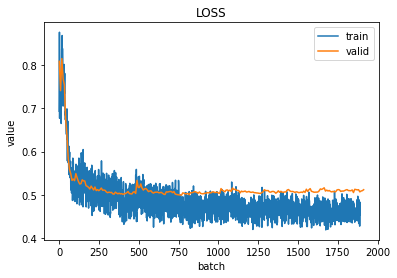

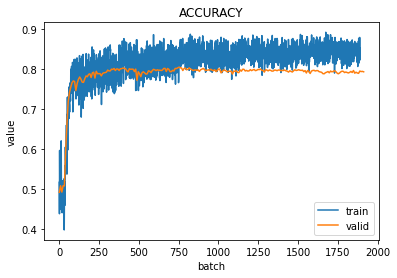

Testing loss = 0.543949
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       158
           1       0.74      0.74      0.74       143

    accuracy                           0.75       301
   macro avg       0.75      0.75      0.75       301
weighted avg       0.75      0.75      0.75       301



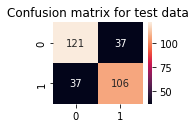

In [ ]:
plt.figure()
plt.plot(train_loss_vec)
plt.plot(np.arange(len(valid_loss_vec)) * period, valid_loss_vec)
plt.xlabel('batch')
plt.ylabel('value')
plt.title('LOSS')
plt.legend(['train', 'valid'])
plt.show()

plt.figure()
plt.plot(train_acc_vec)
plt.plot(np.arange(len(valid_acc_vec)) * period, valid_acc_vec)
plt.xlabel('batch')
plt.ylabel('value')
plt.title('ACCURACY')
plt.legend(['train', 'valid'])
plt.show()

for val_batch in test_iterator:
  text, text_lengths = val_batch.text
  label = val_batch.label

  if torch.cuda.is_available():
    text = text.cuda()
    label = label.cuda()

  net.eval()
  with torch.no_grad():
    predictions = net(text, text_lengths)
    predictions = predictions.squeeze(1)
    
    val_loss = criterion(predictions, label.to(torch.long))
    print(f'Testing loss = {val_loss.item():.6f}')
    print(classification_report(label.to(torch.long).cpu().numpy(), torch.argmax(predictions, dim=1).cpu().numpy()))

    val_conf =  confusion_matrix(label.to(torch.long).cpu().numpy(), torch.argmax(predictions, dim=1).cpu().numpy())
    plt.figure(figsize=(2,1.5))
    plt.title('Confusion matrix for test data')
    sn.heatmap(val_conf, annot=True, annot_kws={"size":10}, fmt='d')
    plt.show()
   

## **Bert Model**

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocessingText(text):
  text = text[0]
  if re.search('\w+:\/\/\S+', text) is not None:
    return [-1]

  text = re.sub('\w+:\/\/\S+', '', text)
  text = re.sub('((?<=[^A-Za-z])\')|(\'(?=[^A-Za-z]))', '', text)
  text = re.sub('@\S+', '', text)
  text = re.sub('[^A-Za-z0-9\s\']', '', text)
  text = re.sub('rt', '', text)
  text = re.sub('\s+', ' ', text)
  text = re.sub('(^\s+)|(\s+$)', '', text)
  text = text.lower()
  tokens = tokenizer.tokenize(text)
  ids = tokenizer.convert_tokens_to_ids(tokens)
  return ids

def preprocessingLabel(label):
  return float(label) / 4.0

def filter_pred(example):
  if example.text is None or len(example.text) == 0 or 0.4 < float(example.label) < 0.6 or example.text[-1] == -1:
    return False
  return True

TEXT = data.Field(tokenize=lambda x: [x], preprocessing=preprocessingText, batch_first=True, use_vocab=False, 
                  pad_token=tokenizer.convert_tokens_to_ids(['[PAD]'])[0], unk_token=tokenizer.convert_tokens_to_ids(['[UNK]'])[0])
LABEL = data.LabelField(dtype=torch.float, preprocessing=preprocessingLabel)

fields = [('label', LABEL), ('id', None), ('date', None), ('query', None), ('name', None), ('text', TEXT), ('category', None)]

path = '/content/drive/MyDrive/Colab Notebooks/Deep/HW3/Sentiment140/training.1600000.processed.noemoticon.utf8.csv'
dataset = data.TabularDataset(path=path, format='CSV', fields=fields, skip_header=False, filter_pred=filter_pred)
(train_data, valid_data) = dataset.split(split_ratio=[0.99, 0.01])

path = '/content/drive/MyDrive/Colab Notebooks/Deep/HW3/Sentiment140/testdata.manual.2009.06.14.csv'
test_data = data.TabularDataset(path=path, format='CSV', fields=fields, skip_header=False, filter_pred=filter_pred)

LABEL.build_vocab(dataset)

print("Number of train data: {}".format(len(train_data)))
print("Number of valid data: {}".format(len(valid_data)))
print("Number of test data: {}".format(len(test_data)))


100%|██████████| 231508/231508 [00:00<00:00, 11710685.75B/s]


Number of train data: 1511128
Number of valid data: 15264
Number of test data: 301


In [ ]:
# Part d
class BertTagger(nn.Module):

  def __init__(self, output_dim=2):
    super(BertTagger, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')

    embedding_dim = self.bert.config.to_dict()['hidden_size']
    self.linear = nn.Linear(embedding_dim, output_dim)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, ids):
    encoded_layers, pooled_output = self.bert(ids.to(torch.int32), output_all_encoded_layers=False)
    print(encoded_layers[:, -1, :], pooled_output)
    tag_scores = self.linear(bert_out[0][:, -1, :])
    tag_probs = self.softmax(tag_scores)
    return tag_probs


## **Training**

In [ ]:
# Part d
OUTPUT_DIM = 2
BATCH_SIZE = 16

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), sort_within_batch=True)

net = BertTagger(OUTPUT_DIM)
if torch.cuda.is_available():
  net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5)


In [ ]:
# cleaning gpu memory
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_loss_vec = []
train_acc_vec = []

valid_loss_vec = []
valid_acc_vec = []

num_epochs = 5
period = max(round(len(train_iterator) / 50.0), 1)

for epoch in range(num_epochs):
  
  pbar = tqdm(train_iterator, total=len(train_iterator), leave=True, position=0)

  tr_epoch_loss = 0
  tr_epoch_acc = 0
  tr_count = 0

  for batch in pbar:
    text = batch.text
    label = batch.label

    if torch.cuda.is_available():
      text = text.cuda()
      label = label.cuda()
      
    net.train()
    optimizer.zero_grad()
    predictions = net(text)
    predictions = predictions.squeeze(1)
    
    loss = criterion(predictions, label.to(torch.long))
    acc = torch.sum(torch.argmax(predictions, dim=1) == label.to(torch.long)) / len(label)

    loss.backward()
    optimizer.step()

    tr_loss = loss.item()
    tr_acc = acc.item()

    train_loss_vec.append(tr_loss)
    train_acc_vec.append(tr_acc)
    
    tr_epoch_loss += tr_loss
    tr_epoch_acc += tr_acc
    
    if tr_count % period == 0:
      val_batch_loss = 0
      val_batch_acc = 0
      val_count = 0

      for val_batch in valid_iterator:
        text = val_batch.text
        label = val_batch.label

        if torch.cuda.is_available():
          text = text.cuda()
          label = label.cuda()

        net.eval()
        with torch.no_grad():
          predictions = net(text)
          predictions = predictions.squeeze(1)
          
          val_loss = criterion(predictions, label.to(torch.long))
          val_acc = torch.sum(torch.argmax(predictions, dim=1) == label.to(torch.long)) / len(label)
          
          val_batch_loss += val_loss.item()
          val_batch_acc += val_acc.item()
          val_count += 1
      
      val_batch_loss = val_batch_loss / val_count
      val_batch_acc = val_batch_acc / val_count
      
      valid_loss_vec.append(val_batch_loss)
      valid_acc_vec.append(val_batch_acc)
    
    tr_count += 1
    pbar.set_description(f'Training: loss={tr_loss:.6f} acc={tr_acc:.3f} | Validation: loss={val_batch_loss:.6f} acc={val_batch_acc:.3f} | epoch={epoch + 1}/{num_epochs}')
  
  tr_epoch_loss = tr_epoch_loss / tr_count
  tr_epoch_acc = tr_epoch_acc / tr_count
  print(f'Training: epoch loss={tr_epoch_loss:.6f}, epoch acc={tr_epoch_acc:.3f} | Validation: epoch loss={val_batch_loss:.6f}, epoch acc={val_batch_acc:.3f} | epoch={epoch + 1}/{num_epochs}')
  print()


Training: loss=0.663348 acc=0.625 | Validation: loss=0.484520 acc=0.818 | epoch=1/5:  11%|█▏        | 10786/94446 [49:50<6:26:33,  3.61it/s]


KeyboardInterrupt: ignored

## **Evaluation**

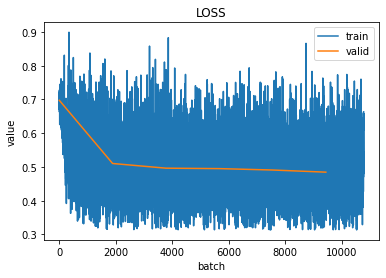

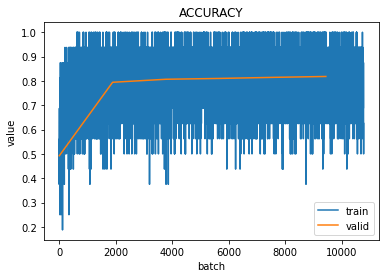


Training: loss=0.506930 acc=0.795
Validation: loss=0.484520 acc=0.818
Testing: loss=0.471950 acc=0.833

              precision    recall  f1-score   support

           0       0.88      0.80      0.83       158
           1       0.80      0.87      0.83       143

    accuracy                           0.83       301
   macro avg       0.84      0.84      0.83       301
weighted avg       0.84      0.83      0.83       301



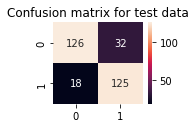

In [ ]:
plt.figure()
plt.plot(train_loss_vec)
plt.plot(np.arange(len(valid_loss_vec)) * period, valid_loss_vec)
plt.xlabel('batch')
plt.ylabel('value')
plt.title('LOSS')
plt.legend(['train', 'valid'])
plt.show()

plt.figure()
plt.plot(train_acc_vec)
plt.plot(np.arange(len(valid_acc_vec)) * period, valid_acc_vec)
plt.xlabel('batch')
plt.ylabel('value')
plt.title('ACCURACY')
plt.legend(['train', 'valid'])
plt.show()

preds = torch.tensor([[0, 0]])
trues = torch.tensor([0])

val_batch_loss = 0
val_batch_acc = 0
val_count = 0
  
val_batch_loss = 0
val_batch_acc = 0
val_count = 0

for val_batch in test_iterator:
  text = val_batch.text
  label = val_batch.label
  
  trues = torch.cat((trues, label), dim=0)

  if torch.cuda.is_available():
    text = text.cuda()
    label = label.cuda()

  net.eval()
  with torch.no_grad():
    predictions = net(text)
    predictions = predictions.squeeze(1)

    preds = torch.cat((preds, predictions.cpu()), dim=0)
    
    val_loss = criterion(predictions, label.to(torch.long))
    val_acc = torch.sum(torch.argmax(predictions, dim=1) == label.to(torch.long)) / len(label)
    
    val_batch_loss += val_loss.item()
    val_batch_acc += val_acc.item()
    val_count += 1

val_batch_loss = val_batch_loss / val_count
val_batch_acc = val_batch_acc / val_count

print()
print(f'Training: loss={sum(train_loss_vec) / len(train_loss_vec):.6f} acc={sum(train_acc_vec) / len(train_acc_vec):.3f}')
print(f'Validation: loss={valid_loss_vec[-1]:.6f} acc={valid_acc_vec[-1]:.3f}')
print(f'Testing: loss={val_batch_loss:.6f} acc={val_batch_acc:.3f}')
print()

print(classification_report(trues[1:].to(torch.long).numpy(), torch.argmax(preds[1:], dim=1).numpy()))

val_conf = confusion_matrix(trues[1:].to(torch.long).numpy(), torch.argmax(preds[1:], dim=1).numpy())
plt.figure(figsize=(2,1.5))
plt.title('Confusion matrix for test data')
sn.heatmap(val_conf, annot=True, annot_kws={"size":10}, fmt='d')
plt.show()
   